# Testing the Markov Assumption with POS Tagging

Part-of-speech (POS) tagging is a Natural Language Processing (NLP) task that attempts to assign a grammatical tag (e.g. "NN" for singular noun and "NNS" for plural noun) to every word in a sentence or collection of sentences. 

Although POS tagging has been a subject of research since the 1960s, it is still considered an unsolved problem today. State-of-the-art techniques have stalled in recent years, unable to crack the 98% accuracy barrier, and the neural network boom has not provided the type of performance increases to POS taggers that have been seen in other fields.

98% accuracy may sound high, but there are two big caveats. First, POS tagging is implemented at the word-level, and a large corpus may have billions of words. A 2% error rate at this level of magnitude, therefore, produces tens of millions of errors. Second, it should be noted that POS tagging has an extremely high baseline accuracy. We can achieve about 13% accuracy on a corpus simply by tagging every word as a noun, and can achieve about 62% accuracy on a corpus by taking the top 100 most frequent words and tagging any occurrence of those words with the most frequent tag for that word. By tagging all words with their most frequent tag (a simple probabilistic model), we can achieve over 80% accuracy. Using another simple tool, a Hidden Markov Model, we can often achieve around 90% accuracy. Given these extremely high baselines, 98% accuracy begins to seem rather unimpressive.

In this notebook, we will explore some of the basics of POS tagging, taking a close look at baseline accuracies, the Markov assumption, and Hidden Markov Models, and will ultimately test whether or not the Markov assumption holds.

## Preparation

### Libraries Used

In [1]:
from nltk.corpus import treebank, brown
from nltk.tag.sequential import NgramTagger, UnigramTagger
from nltk import FreqDist, ConditionalFreqDist, DefaultTagger

from sklearn.utils import resample

import time
from collections import Counter
import numpy as np
from scipy.stats import norm, ttest_ind

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

### Gathering Data

The NLTK library comes with several corpora, including the popular Treebank and Brown sets, both of which were hand-tagged with the correct part-of-speech. Having a training set where we are certain of the correct POS tags is vital to our ability to test our model accuracy.

In [2]:
# Note: Before you can access the NLTK corpora, you will need to download to your computer:
import nltk
nltk.download('treebank')
nltk.download('brown')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\astachn1\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\astachn1\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In order to simplify the process of pulling corpora from NLTK, we create two helper functions. The first simply returns a list of sentences that contain word/tag tuples, and the second ensures that all words are lowercase. This second function is important, for example, if we want to treat "The" and "the" as the same word.

In [3]:
def pull_tagged_sents (corpus):
    '''When passed an NLTK corpus that contains pre-tagged POS, returns a list of sentences
    that contain word/tag tuples.'''
    temp_list = []
    # Iterate through the files in the corpus
    for fileid in corpus.fileids():
        # We use extend to create a list of lists
        # Outer List [  *** contains lists of sentences ***  ]
        # Inner Lists [  *** contain tuples of word, tag pairs *** ]
        temp_list.extend(corpus.tagged_sents(fileid))
    print('Number of sentences: {}'.format(len(temp_list)))
    return temp_list

def replace_uppercase (sentences):
    '''Iterates through sentences of word/tag tuples and returns all lowercase words.'''
    new_sentences = []
    # Iterate through sentences
    for sentence in sentences:
        new_sentence = []
        # Iterate through word/tag tuples
        for (word, tag) in sentence:
            # Replace words with lowercase
            new_sentence.append((word.lower(), tag))
        new_sentences.append(new_sentence)
    return new_sentences

In [4]:
# Pull treebank data from NLTK
treebank_tagged_sents = pull_tagged_sents(treebank)

Number of sentences: 3914


In [5]:
# Pull brown data from NTLK
brown_tagged_sents = pull_tagged_sents(brown)

Number of sentences: 57340


As we can see, the Brown corpus is much larger than Treebank. 

In [6]:
# Replace any uppercase words with lowercase
treebank_tagged_sents = replace_uppercase(treebank_tagged_sents)
brown_tagged_sents = replace_uppercase(brown_tagged_sents)

## Baseline Results

### Baseline Using Most Frequent Tag

The absolute simplest POS tagger would tag every word with the most frequent tag. This is similar to a predictive model which always predicts the majority class in an imbalanced dataset, thereby earning a falsely high accuracy score.

In almost any corpus, the most frequent tag will be "NN" for "singular noun." Below we can see that a little more than 13% of all words in Treebank are singular nouns.

In [7]:
# Initialize list
POS_tags = []
# Iterate through sentences in training set
for sent in treebank_tagged_sents:
    # Create a list of all tags in the corpus
    POS_tags.extend([tag for (_, tag) in sent])
# Build a frequency distribution of tags
tag_dist = FreqDist(POS_tags)
# Determine the most frequent tag
most_freq_tag = FreqDist(POS_tags).max()
# Determine the frequency rate of that tag
most_freq_tag_rate = tag_dist[most_freq_tag] / len(POS_tags)
print('{0}: {1:.2f}%'.format(most_freq_tag, most_freq_tag_rate * 100))

NN: 13.08%


Using this information, we can build a tagger which will tag every word in a sentence as "NN". Below we demonstrate this method on a test sentence from the Treebank corpus, proving that our tagger functions as expected. Finally, we demonstrate the overall accuracy of the tagger (which, in this case, will be the same as the frequency distribution of "NN" in the full corpus). This rate should function as our baseline accuracy for tagging.

In [8]:
# Build a tagger that will tag all words by the most frequent tag in training set
max_freq_tagger = DefaultTagger(most_freq_tag)

In [9]:
# Gather and print a test sentence
test_sentence = [i[0] for i in treebank_tagged_sents[0]]
print(' '.join(test_sentence))

pierre vinken , 61 years old , will join the board as a nonexecutive director nov. 29 .


In [10]:
# Tag the test sentence to demonstrate functionality
max_freq_tagger.tag(test_sentence)

[('pierre', 'NN'),
 ('vinken', 'NN'),
 (',', 'NN'),
 ('61', 'NN'),
 ('years', 'NN'),
 ('old', 'NN'),
 (',', 'NN'),
 ('will', 'NN'),
 ('join', 'NN'),
 ('the', 'NN'),
 ('board', 'NN'),
 ('as', 'NN'),
 ('a', 'NN'),
 ('nonexecutive', 'NN'),
 ('director', 'NN'),
 ('nov.', 'NN'),
 ('29', 'NN'),
 ('.', 'NN')]

In [11]:
# Demonstrate the accuracy of the tagger
max_freq_tagger.evaluate(treebank_tagged_sents)

0.13077595454726051

### Baseline Using Top 100 Most Frequent Words
As our next baseline, we will extend the default tagger above to first check if the word is one of the top 100 most frequent words in the corpus. If so, it will tag that word with the most frequent tag for that particular word (e.g. "run" is most commonly a verb). If the word is not in the top 100, the tagger will "back off" to tagging all words as "NN". This is known as <b>backoff smoothing</b>, and is commonly used in POS taggers.

In [12]:
# Initialize a Counter object from collections
vocab_counts = Counter()
# Iterate through sentences
for sent in treebank_tagged_sents:
    # Update the vocab counts
    vocab_counts.update([word_tuple[0] for word_tuple in sent])

In [13]:
# Gather the 100 most frequent words in training set
top_100 = vocab_counts.most_common(100)
top_100[:8]

[(',', 4885),
 ('the', 4764),
 ('.', 3828),
 ('of', 2325),
 ('to', 2182),
 ('a', 1988),
 ('in', 1769),
 ('and', 1556)]

In [14]:
# Build a Conditional Frequency Distribution, which will return the tag distribution for each word
all_sents = []
# Iterate through sentences in training set
for sent in treebank_tagged_sents:
    # Collate all sentences for later use with conditional frequency
    all_sents.extend(sent)
conditional_freq = ConditionalFreqDist(all_sents)

In [15]:
# Build a dictionary of the 100 most frequent words and their most frequent tag
top_100_top_tags = {}
for (word, _) in top_100:
    top_100_top_tags[word] = conditional_freq[word].max()

In [16]:
# Build a new default tagger that first tags using the conditional distributions of the top 100 words
# and then backs off to the most frequent tag
top_100_tagger = UnigramTagger(model=top_100_top_tags, backoff=max_freq_tagger)

In [17]:
# Tag the test sentence to demonstrate functionality
top_100_tagger.tag(test_sentence)

[('pierre', 'NN'),
 ('vinken', 'NN'),
 (',', ','),
 ('61', 'NN'),
 ('years', 'NNS'),
 ('old', 'NN'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'NN'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'NN'),
 ('director', 'NN'),
 ('nov.', 'NN'),
 ('29', 'NN'),
 ('.', '.')]

In [18]:
# Demonstrate the accuracy of the tagger
top_100_tagger.evaluate(treebank_tagged_sents)

0.6135325201636934

Wow! What a difference incorporating the top 100 words made! It may seem surprising that we can achieve over 61% accuracy using such a simple tagger, but the reason is simple: many of the most frequent words or punctuation characters are given their own tag in the Penn Treebank tagging system. For example, the word "to" is always tagged as "TO" just as "the" will always be a determiner, "DET". The same applies to commas and periods. 

Another way of viewing this is to recognize that the Penn Treebank tags were invented by researchers to solve the problem of POS tagging. As such, they took shortcuts to make the task easier. The word "to" has many varying uses in the English language, but it certainly is easy to tag correctly if we assign it its own tag. Similarly, assigning the "," tag to a comma cannot tell us whether the punctuation mark is separating a list of nouns or two independent clauses - we are simply verifying that it's a comma.

The point of demonstrating this as a baseline tagger is to make it clear that a high percentage of words in any corpora can be correctly tagged with almost no effort, simply because the tags for the most frequent words are nearly foolproof.

## Hidden Markov Models

Before we get into Hidden Markov Models, we need to understand the <b>Markov Assumption</b>. The Markov Assumption is that we can represent the probability of a state only by the previous state, or that:

$$P(q_i|q_1…q_{i-1}) = P(q_i|q_{i-1})$$

According to the Markov Assumption, the accuracy of POS tagging using only the state before the state in question should be as accurate as using more than one previous state. We will test this assumption below by comparing to models that use multiple previous states.

A Hidden Markov Model (HMM) is just a Markov process that includes hidden states as well. A simple way to think of this in terms of POS tagging is that we can base the predicted tag of our current word on 1) the tag of the previous word, and 2) the probabilistic tag of the current word based on the frequency distribution for that word.

The first part is "visible" to us, so long as we are tagging each word in a sentence in sequential order. The second part, called the emission probability, is "hidden", or not directly known from the previous state. To understand why a HMM might help in POS tagging, consider the phrase "to fish". By itself, "fish" might be more commonly used as a noun; let's say 60% of the time it's a noun, and 40% verb. However, we know that the presence of "to" directly before the word suggests that it is probably being used as a verb. Using both together, we can assign a probability that "fish" is a verb versus a noun.

When tagging a sentence using a HMM, the Viterbi algorithm is generally used to manage these various probabilistic outputs and choose the best path. In the Viterbi algorithm, we generate all possible probabilistic paths from sentence beginning to sentence end. Then, we move backwards from the end, choosing the highest probability at each stage.

### Experimental Results

Experimental results were evaluated using bootstrapping. Because Hidden Markov Model POS taggers assume a hard barrier at the beginning and end of each sentence, sentence order does not matter and we can safely consider sentences to be independent observations. We therefore can randomly sample a set of sentences to use for training and testing purposes. In this case study, we use a standard bootstrapping method where we randomly sample sentences with replacement until we have the same length as the original number of sentences. Any sentences not chosen then form the test set. We perform 100 iterations.

For each bootstrapped training set, a vocabulary is built, and any words with a frequency of occurrence less than 5 are removed from the vocabulary to form a reduced vocabulary. For all words in the bootstrapped training and test sets, any word not in the reduced vocabulary is replaced with the “UNK” token. A default tagger is built using whatever the most frequent tag is in the bootstrapped training set. Then, the top 100 words in order of frequency of occurrence are used to create the “0-gram” tagger, which will backoff to the default tagger for all other words. For all n-grams from 1 to 5 (the maximum n-gram length considered), an n-gram tagger is built which backs off to the previous n-gram for unseen occurrences. So, the 2-gram tagger would back off to the 1-gram tagger, which would back off to the 0-gram tagger (which uses the top 100 words), which in turn backs off to the default tagger. In this way, the taggers always have a fallback for unseen occurences.

Each n-gram tagger is evaluated on the bootstrapped test set, and the overall accuracy and time-to-tag are reported.

The functions below will help keep our code DRY, and should be self-explanatory for the most part. The last function, evaluate_n_grams, is simply a wrapper that puts everything together and governs the flow of our multiple tests.

In [19]:
def build_vocab_counts (training_set, threshold=5):
    '''Build a Counter object of word/count key/values. Also returns a standard
    Python dictionary which ignores any words with a count below the threshold.'''
    # Initialize a Counter object from collections
    vocab_counts = Counter()
    # Iterate through sentences
    for sent in training_set:
        # Update the vocab counts
        vocab_counts.update([word_tuple[0] for word_tuple in sent])
    # Also build a dictionary of words above the minimum threshold count
    vocab_counts_above_min = {word: count for word, count in vocab_counts.items() if count > threshold}
    return vocab_counts, vocab_counts_above_min

In [20]:
def replace_low_freq_words (sentences, vocab):
    '''A function to iterate through word/tag tuples in a list of sentences that
    replaces low frequency words with 'UNK' token.'''
    new_sentences = []
    # Iterate through sentences
    for sentence in sentences:
        new_sentence = []
        # Iterate through word/tag tuples
        for (word, tag) in sentence:
            # Replace low frequency words with 'UNK'
            if word not in vocab:
                word = 'UNK'
            new_sentence.append((word, tag))
        new_sentences.append(new_sentence)
    return new_sentences

In [21]:
def test_accuracy (test_set, tagger):
    '''A function to determine the accuracy of a tagger. Returns more information
    than the NLTK .evaluate method.'''
    # Initialize counters
    total_correct = 0
    total_obs = 0
    extended_y = []
    extended_y_pred = []
    # Initialize timer
    t0 = time.time()
    for sent in test_set:
        # Split into x (word) and y (tag)
        x = [w[0] for w in sent]
        y = [w[1] for w in sent]
        # Make predictions using HMM tagger
        y_pred = [w[1] for w in tagger.tag(x)]
        # Add up the total number of observations
        total_obs += len(y)
        # Add up the total number of correct predictions
        # Note the use of np.core.defchararray.equal instead of np.equal
        # as we are comparing strings
        total_correct += np.sum(np.core.defchararray.equal(y, y_pred))
    # Update timer
    t1 = time.time()
    time_to_tag = t1 - t0
    # Determine overall accuracy
    acc = total_correct / total_obs
    return total_correct, total_obs, acc, time_to_tag

In [22]:
class Bootstrap_Indices:
    '''A cross-validation iterator that will work with GridSearchCV.
    The iterator uses Sci-Kit Learn's resample method to sample with replacement and
    uses Numpy's in1d method to determine which indices will be in the test set. Also
    relies on Numpy's arange method.

    @ Parameters:
    ---------------
    n: number of observations
    m: number of times to sample with replacement

    @ Returns:
    ---------------
    an iterable of idx_train, idx_test indices
    '''

    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.i = 0

    def __len__(self):
        return self.m

    def __iter__(self):
        idx = np.arange(self.n)
        while self.i < self.m:
            self.i += 1
            idx_train = resample(idx)
            mask = np.in1d(idx, idx_train, invert=True)
            idx_test = idx[mask]
            yield idx_train, idx_test

In [23]:
def evaluate_n_grams(data, max_n=5, **kwargs):
    '''A wrapper function that evaluates various n-gram taggers and returns results.
    
    @ Parameters:
    ---------------
    data: a list of sentences on which to test tagging
    max_n: The maximum number of elements to consider in a Markov chain
    
    @ Optional Keyword Arguments:
    ---------------
    bootstrap_m: the number of bootstrapping samples to test
    min_freq_threshold: the minimum number of times a word must appear (otherwise replaced with <UNK>)

    @ Returns:
    ---------------
    an iterable of idx_train, idx_test indices
    '''
    
    # Gather optional keyword arguments
    bootstrap_m = kwargs.pop('bootstrap_m', 100)
    min_freq_threshold = kwargs.pop('min_freq_threshold', 5)

    # Initialize a storage dictionary
    temp_dict = {}
    # Iterate through the possible values of n
    for n in range(max_n + 1):
        temp_dict[n] = {}
        temp_dict[n]['total_correct'] = np.array([])
        temp_dict[n]['total_obs'] = np.array([])
        temp_dict[n]['acc'] = np.array([])
        temp_dict[n]['time_to_tag'] = np.array([])

    # Create a bootstrap iterator
    bootstrap = Bootstrap_Indices(len(data), bootstrap_m)
    counter = 0

    # For each bootstrap iteration
    for x_ix, y_ix in bootstrap:
        
        # Gater data into training and testing sets
        training_set = [data[i] for i in x_ix]
        testing_set = [data[i] for i in y_ix]

        # Build a vocab counter for training set
        vocab_counts, vocab_counts_above_min = build_vocab_counts(training_set, threshold=min_freq_threshold)

        # Replace low frequency words with UNK
        training_set_updated = replace_low_freq_words(training_set, vocab_counts_above_min)
        testing_set_updated = replace_low_freq_words(testing_set, vocab_counts_above_min)

        # Iterate through the possible values of n
        for n in range(max_n + 1):

            if n == 0:
                # Initialize lists
                POS_tags = []
                all_sents = []
                # Iterate through sentences in training set
                for sent in training_set:
                    # Create a list of all tags in the corpus
                    POS_tags.extend([tag for (_, tag) in sent])
                    # Collate all sentences for later use with conditional frequency
                    all_sents.extend(sent)
                # Determine the most frequent tag
                most_freq_tag = FreqDist(POS_tags).max()
                # Build a default tagger that will tag all words by the most frequent tag in training set
                max_freq_tagger = DefaultTagger(most_freq_tag)
                # Gather the 100 most frequent words in training set
                top_100 = vocab_counts.most_common(100)
                # Build a Conditional Frequency Distribution, which will return the tag distribution for each word
                conditional_freq = ConditionalFreqDist(all_sents)
                # Build a dictionary of the 100 most frequent words and their most frequent tag
                top_100_top_tags = {}
                for (word, _) in top_100:
                    top_100_top_tags[word] = conditional_freq[word].max()
                # Build a new default tagger that first tags using the conditional distributions of the top 100 words
                # and then backs off to the most frequent tag
                temp_dict[n]['tagger'] = UnigramTagger(model=top_100_top_tags, backoff=max_freq_tagger)

            else:
                # Initialize n-gram HMM tagger that uses n-1 -gram tagger for backoff
                # Note the use of the updated training set with 'UNK' words
                temp_dict[n]['tagger'] = NgramTagger(n, train=training_set_updated, backoff=temp_dict[n - 1]['tagger'])

            # Evaluate each model and save results
            total_correct, total_obs, acc, time_to_tag = test_accuracy(testing_set_updated, temp_dict[n]['tagger'])
            temp_dict[n]['total_correct'] = np.append(temp_dict[n]['total_correct'], total_correct)
            temp_dict[n]['total_obs'] = np.append(temp_dict[n]['total_obs'], total_obs)
            temp_dict[n]['acc'] = np.append(temp_dict[n]['acc'], acc)
            temp_dict[n]['time_to_tag'] = np.append(temp_dict[n]['time_to_tag'], time_to_tag)

        counter += 1

    return temp_dict

In [24]:
treebank_results = evaluate_n_grams(treebank_tagged_sents, max_n=5)
brown_results = evaluate_n_grams(brown_tagged_sents, max_n=5)

### Results
The functions below make it simple to review the overall accuracy of our POS taggers.

In [25]:
def plot_results (result_dict, corpus_name):
    '''A function to plot both accuracy and time-to-tag results in one graph.'''
    # Initialize plot
    fig, ax = plt.subplots()
    # Sort the results by n-gram number
    x = sorted(result_dict.keys())
    
    # Append accuracy and time to lists
    acc = []
    time = []
    for n in x:
        acc.append(np.mean(result_dict[n]['acc']))
        time.append(np.mean(result_dict[n]['time_to_tag']))

    # Plot accuracy and set options
    line1 = ax.plot(x, acc, color='C0', label='Accuracy')
    ax.set_title('POS Tagging on {} Corpus'.format(corpus_name))
    ax.set_xticks(x)
    ax.set_xlabel('Number of n-grams considered')
    ax.set_ylim([0.60, 1.00])
    ax.set_ylabel('Overall Tagging Accuracy')

    # Plot time on the same axis
    ax_time = ax.twinx()
    line2 = ax_time.plot(x, time, color='C1', label='Time to Tag')
    ax_time.set_ylabel('Time to Tag (in seconds)')
    
    # Setting up legend
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc=4)

    plt.show()

In [26]:
def print_results(data, measure, title, **kwargs):
    '''A function to print Mean, Stdev, and Conf Interval results.'''
    C = kwargs.pop('C', 0.95)
    print('{} POS Tagging Results'.format(title))
    for n in sorted(data.keys()):
        # Calculate confidence interval
        conf = norm.interval(C, loc=data[n][measure].mean(), scale=data[n][measure].std()) 
        print('{0}-gram\tMean: {1:.2f} Std: {2:.4f} 95%Conf: ({3:.2f}, {4:.2f})'.format(n, data[n][measure].mean(), data[n][measure].std(), conf[0], conf[1]))

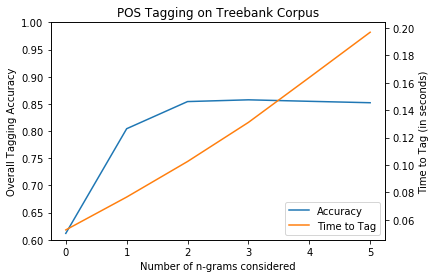

Treebank POS Tagging Results
0-gram	Mean: 0.61 Std: 0.0022 95%Conf: (0.61, 0.62)
1-gram	Mean: 0.80 Std: 0.0023 95%Conf: (0.80, 0.81)
2-gram	Mean: 0.85 Std: 0.0024 95%Conf: (0.85, 0.86)
3-gram	Mean: 0.86 Std: 0.0021 95%Conf: (0.85, 0.86)
4-gram	Mean: 0.85 Std: 0.0020 95%Conf: (0.85, 0.86)
5-gram	Mean: 0.85 Std: 0.0019 95%Conf: (0.85, 0.86)


In [27]:
plot_results(treebank_results, 'Treebank')
print_results(treebank_results, 'acc', 'Treebank')

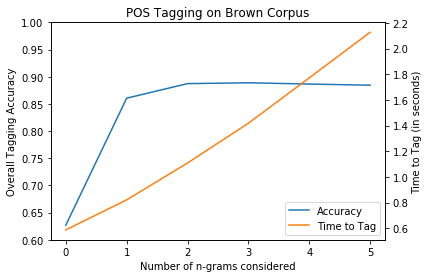

Brown POS Tagging Results
0-gram	Mean: 0.63 Std: 0.0008 95%Conf: (0.63, 0.63)
1-gram	Mean: 0.86 Std: 0.0006 95%Conf: (0.86, 0.86)
2-gram	Mean: 0.89 Std: 0.0006 95%Conf: (0.89, 0.89)
3-gram	Mean: 0.89 Std: 0.0006 95%Conf: (0.89, 0.89)
4-gram	Mean: 0.89 Std: 0.0006 95%Conf: (0.89, 0.89)
5-gram	Mean: 0.88 Std: 0.0006 95%Conf: (0.88, 0.89)


In [28]:
plot_results(brown_results, 'Brown')
print_results(brown_results, 'acc', 'Brown')

As can be seen above, for both corpora we begin with a fairly high baseline tagging accuracy around 62% for the “0-gram” tagger. The “1-gram” tagger, which only considers the emission probabilities for each word in a sentence brings the tagging accuracy up to 80% for Treebank and 86% for Brown. The first true Hidden Markov Model (considers both transition probabilities of previous word and emission probabilities of current word), then, the “2-gram” tagger, improves accuracy to 85% for Treebank and 89% for Brown. This does not seem like much of an improvement, but it should be noted that for Treebank we are making around 37,000 predictions, and for Brown about 425,000. An increase of three percentage points in overall accuracy in the Brown corpus, therefore, translates to almost 13,000 additional correct predictions.

Most importantly, it can be observed that there is almost no increase in performance past the “2-gram” tagger. By the eye test, the Markov assumption appears to hold true. However, it is required that we go past a simple eye test. When running a student’s T-test at alpha=0.05, it can be observed (see below) that there is a statistically significant improvement in accuracy for the “3-gram” tagger for both the Treebank and Brown corpora. There is no improvement in accuracy over the “2-gram” model for the “4-gram” and “5-gram” models, and this flat-lining in accuracy can be directly observed in figures 1 and 2.

### Testing for Significance

In [29]:
def compare_scores (*args, alternate='less', **kwargs):
    '''Function performs a series of t-tests, comparing the first element in *args to all 
    other elements. To avoid increasing the likelihood of making a Type I error, we use the
    Bonferroni method, which divides the alpha value by the number of hypotheses tested.
    
    The T-test function provided in SciPy always produces a two-side test, but the user
    can choose a one-sided test by supplying the necessary parameter.
    
    We would reject the null hypothesis when:
        * H0: a <= b, Ha: a > b : reject H0 when p/2 < alpha and t > 0
        * H0: a >= b, Ha: a < b : reject H0 when p/2 < alpha and t < 0
        * H0: a = b, Ha: a != b : reject H0 when p < alpha
        
    @ Parameters:
    ---------------
    *args: list of score arrays, where first in list is compared to all others
    alternate: value of "less", "more", or "unequal" - will determine test that is run.
        User should assume "less" means that they are testing if the scores of the first
        argument are less than the scores of all other arguments.
    
    @ **kwargs (optional):
    ---------------
    alpha: alpha value for testing (function will automatically update if required for
        one-sided test and to take into account Bonferroni method)
    labels: a list of names of the score arrays
    '''
    # Gather keyword arguments, if any
    alpha = kwargs.pop('alpha', 0.05)
    labels = kwargs.pop('labels', ['Model {}'.format(x) for x in range(len(args))])
    
    # Determine appropriate signs for hypotheses
    if alternate == 'less':
        hyp_sign_1 = '>='
        hyp_sign_2 = '<'
        q = 2
    elif alternate == 'more':
        hyp_sign_1 = '<='
        hyp_sign_2 = '>'
        q = 2
    elif alternate == 'unequal':
        hyp_sign_1 = '='
        hyp_sign_2 = '!='
        q = 1
    
    # Determine the Bonferroni correction based on number of hypotheses to test
    m = len(args) - 1
    bonferroni = alpha / m
    
    for arg, label in zip(args[1:], labels[1:]):
        # Calculate t and p
        t_statistic, p_value = ttest_ind(args[0], arg)
        hyp_state = 'Ho: {0} {1} {2}\nHa: {0} {3} {2}\nReject Ho when p/2 < {4} and t {3} 0'.format(labels[0], hyp_sign_1, label, hyp_sign_2, bonferroni)
        hyp_test = '\tT-statistic: {0:.2f}, P-value: {1}'.format(t_statistic, p_value)
        # Determine whether to reject null hypothesis
        if p_value / q < bonferroni:
            if alternate == 'less' and t_statistic < 0:
                res = 'Reject'
            elif alternate == 'more' and t_statistic > 0:
                res = 'Reject'
            elif alternate == 'unequal':
                res = 'Reject'
            else:
                res = 'Fail to reject'
        else:
            res = 'Fail to reject'
        hyp_result = '\t{0} the null hypothesis.'.format(res)
        print('\n'.join([hyp_state, hyp_test, hyp_result]) + '\n')

In [30]:
scores = [treebank_results[n]['acc'] for n in [2,3,4,5]]
names = ['{0}-gram'.format(n) for n in [2,3,4,5]]
compare_scores(*scores, labels=names, alternate='less', alpha=0.05)

Ho: 2-gram >= 3-gram
Ha: 2-gram < 3-gram
Reject Ho when p/2 < 0.016666666666666666 and t < 0
	T-statistic: -10.18, P-value: 7.600067330362548e-20
	Reject the null hypothesis.

Ho: 2-gram >= 4-gram
Ha: 2-gram < 4-gram
Reject Ho when p/2 < 0.016666666666666666 and t < 0
	T-statistic: -1.59, P-value: 0.11361571945586524
	Fail to reject the null hypothesis.

Ho: 2-gram >= 5-gram
Ha: 2-gram < 5-gram
Reject Ho when p/2 < 0.016666666666666666 and t < 0
	T-statistic: 6.91, P-value: 6.387178031562211e-11
	Fail to reject the null hypothesis.



In [31]:
scores = [brown_results[n]['acc'] for n in [2,3,4,5]]
names = ['{0}-gram'.format(n) for n in [2,3,4,5]]
compare_scores(*scores, labels=names, alternate='less', alpha=0.05)

Ho: 2-gram >= 3-gram
Ha: 2-gram < 3-gram
Reject Ho when p/2 < 0.016666666666666666 and t < 0
	T-statistic: -19.29, P-value: 2.4405226546230157e-47
	Reject the null hypothesis.

Ho: 2-gram >= 4-gram
Ha: 2-gram < 4-gram
Reject Ho when p/2 < 0.016666666666666666 and t < 0
	T-statistic: 9.61, P-value: 3.492369299867037e-18
	Fail to reject the null hypothesis.

Ho: 2-gram >= 5-gram
Ha: 2-gram < 5-gram
Reject Ho when p/2 < 0.016666666666666666 and t < 0
	T-statistic: 35.78, P-value: 2.2255837475179055e-88
	Fail to reject the null hypothesis.



As has been statistically shown, then, the Markov Assumption does not entirely hold. However, the Markov Assumption was always just that—an assumption which was known to not perfectly represent reality, but which could make our calculations easier at very little decrease in accuracy. In this way, the Markov Assumption is similar to the naïve assumption in a Naïve Bayes classifier. Although we can increase the accuracy of a POS tagger by considering more than one previous state, there will certainly be a point at which there is no more benefit to be gained. Furthermore, the gains in accuracy may be offset by the increased cost of considering more than one previous state. As can be seen in the plots above, the time-to-tag increases nearly linearly.

As in most things, then, the data practitioner will need to make a decision about whether or not the Markov Assumption is worth trusting. Overall accuracy is not the only metric that will need to be evaluated in such a decision, so it is not possible to make a blanket determination.

# Conclusion
The Markov Assumption is a useful approximation of reality that can make calculations much faster in a Hidden Markov Model. However, data practitioners should be aware that the assumption is just that. The wise data practitioner, therefore, should test the performance of a Hidden Markov Model both with the Markov Assumption and without. The final determination on whether or not to trust this assumption will depend on the needs of each particular use case.